# Boosting Classification and Regression Trees
by Elliot Cohen, Ph.D.  

**Requirements**: Python 3.6 with the following packages: `pandas`, `numpy`, `scikit-learn`, `pydotplus`, `IPython`  
You can install packages directly in a Jupyter Notebook as follows:
```!pip install <package>```

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble

from IPython.display import Image
import pydotplus  # NOTE: May Require conda install graphviz

## Example 1: Predicting Cancer with Classification Trees

In [2]:
# import data
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'

header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [3]:
# divide data into predictors (X) and predictand (y), and subdivide into test/train sets.
Y = data['diagnosis'].replace({'M': 1, 'B': 0}) # convert to binary outcome
X = data.iloc[:, data.columns != 'diagnosis']

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.4)

In [4]:
# fit a classifier
clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

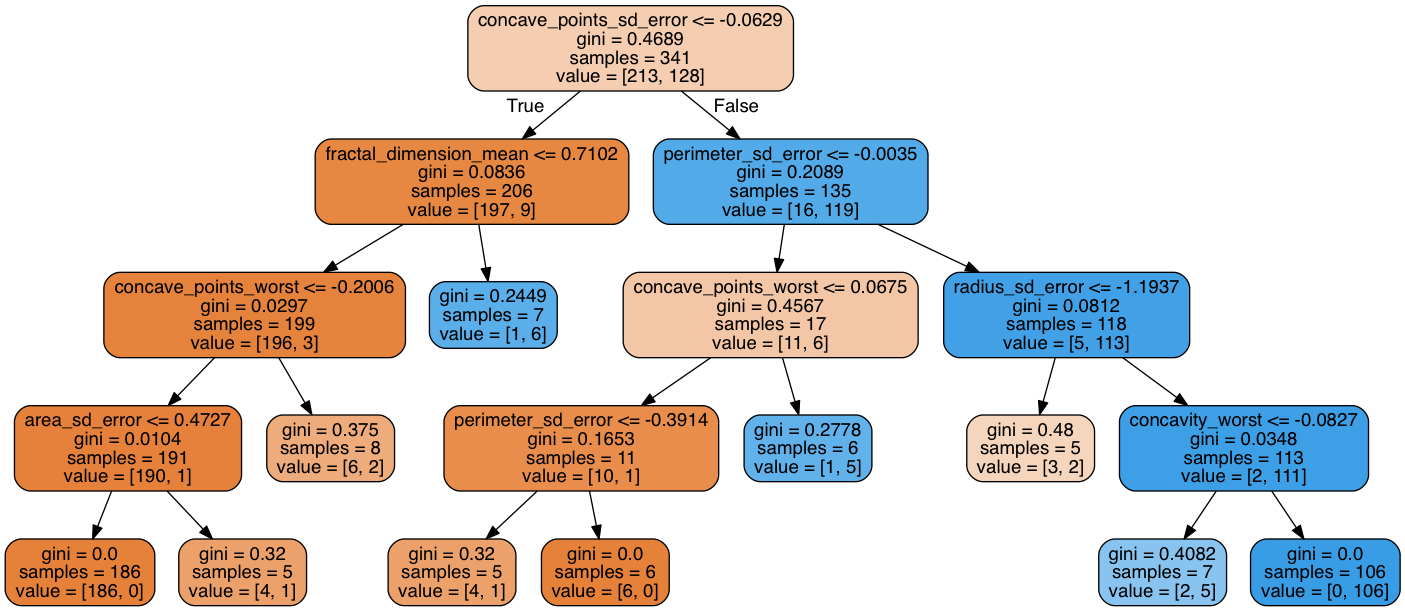

In [5]:
# visualize the classifier
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [6]:
# evaluate feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Feature_importance': clf.feature_importances_})
feature_importance.sort_values('Feature_importance', ascending=False).head(5)

,Feature,Feature_importance
22,concave_points_sd_error,0.789182
7,perimeter_sd_error,0.076410
27,fractal_dimension_mean,0.066105
23,concave_points_worst,0.035844
1,radius_sd_error,0.022383


In [7]:
# compare performance of single decision tree with ensemble classifiers....
print(metrics.classification_report(y_true=Y_test, y_pred=clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.96      0.93      0.94       144
          1       0.89      0.93      0.91        84

avg / total       0.93      0.93      0.93       228



In [8]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    
    # Initialize uniform weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specified weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # Encode misclassifications as binary 0/1
        miss = [int(x) for x in (pred_train_i != Y_train)]
        
        # Encode misclassifications as 1/-1 to update weights (equivalent to above)
        miss2 = [x if x==1 else -1 for x in miss]
        
        # Compute weighted classification error
        err_m = np.dot(w,miss) / sum(w)
        
        # Compute new weights, alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    return pred_train, pred_test

In [12]:
_, y_hat = adaboost_clf(Y_train, X_train, Y_test, X_test, M=1, clf=tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5))
print(metrics.classification_report(y_true=Y_test, y_pred=y_hat))

             precision    recall  f1-score   support

          0       0.96      0.93      0.94       144
          1       0.89      0.93      0.91        84

avg / total       0.93      0.93      0.93       228



**Note**: For M=1 (e.g. an ensemble of 1), we get back the same accuracy as the original classification tree!

In [13]:
# Finally, let's use the fully-implimented version from scikit-learn
clf = ensemble.AdaBoostClassifier()
clf.fit(X_train, Y_train)
print(metrics.classification_report(y_true=Y_test, y_pred=clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.95      0.95       144
          1       0.92      0.92      0.92        84

avg / total       0.94      0.94      0.94       228



## Discussion:
1. Which paramter(s) control under-fitting vs over-fitting?
2. How do we know when to stop feature splits in a "greedy" function?
3. Name one way we can evaluate feature importance?

## Example 2: Regresssion Trees

In [ ]:
# now let's try with a continuous target varialbe
yellow_taxi_url = 'https://raw.githubusercontent.com/Ecohen4/data-viz/project/project/weatherCabDataViz.csv'
taxi_data = pd.DataFrame.from_csv(yellow_taxi_url)
taxi_data.apply(pd.Categorical).describe()

In [ ]:
# visualize a period of interest
start, end = taxi_data.index[0], taxi_data.index[24*90]
taxi_data = taxi_data.loc[start:end]
taxi_data.loc[start:end].occupancy.plot(figsize=(18,6), linewidth=0.2)
taxi_data.loc[start:end].occupancy.rolling(window=48).mean().plot(figsize=(18,6))

In [ ]:
# timeseries cross-validation
def time_series_cross_validation(target, features, classifier, model_name, n_splits=3):
    y = target
    scaler = preprocessing.StandardScaler().fit(features)
    X = scaler.transform(features)
    
    # time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Three subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=False, sharey=False, figsize=(16,8))
    f.subplots_adjust(hspace=0.2)
    axes = [ax1, ax2, ax3]
    evaluation_metric = []
    split = 0
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        classifier.fit(X_train, Y_train)
        y_hat=classifier.predict(X_test)
        explained_variance = metrics.explained_variance_score(y_true=Y_test, y_pred=y_hat)        
        evaluation_metric.append(explained_variance)
        axes[split].plot(pd.DataFrame({'y_hat': y_hat, 'y_true': Y_test}))
        split += 1
    axes[0].set_title('{}\n Mean Cross-Validated Explained Variance Score: {:.2f}'.format(
                    model_name, np.mean(evaluation_metric))
                     )

In [ ]:
time_series_cross_validation(
    target = taxi_data['occupancy'],
    features = taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=tree.DecisionTreeRegressor(max_depth=3),
    model_name='Decision Tree'
)

In [ ]:
# Results are not so good, huh?
# what feature are we missing?
# let's do some feature engineering to see if we can improve our prediction
taxi_data['timeOfDay'] = taxi_data.index.hour

time_series_cross_validation(
    target = taxi_data['occupancy'],
    features = taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=tree.DecisionTreeRegressor(max_depth=3),
    model_name='Decision Tree'
)

### Discussion:
1. How do classificaiton and regression trees differ?
2. What are special considerations for applying CART to timeseries data?
3. What are other types of problems for which CART are well-suited?

## Example 3: Ensemble Methods

In [ ]:
time_series_cross_validation(
    target=taxi_data['occupancy'],
    features=taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=ensemble.RandomForestRegressor(criterion='mse',  # feature-splitting criterion
                                              n_estimators=50, # number of trees
                                              max_depth=5 # max tree depth
                                             ),
    model_name='Random Forest'
)

In [ ]:
time_series_cross_validation(
    target=taxi_data['occupancy'],
    features=taxi_data.loc[:, taxi_data.columns != 'occupancy'],
    classifier=ensemble.GradientBoostingRegressor(criterion='mse', # feature splitting criterion
                                                  loss='lad', # overall loss function to be minimized
                                                  n_estimators=50 # number of trees
                                                 ),
    model_name='Boosted Tree'
)

## Discussion
1. What is the advantage of ensemble methods?
2. What is the disadvantage of ensemble methods?
3. With so many hyperparameters, how do we "tune" our model?